## In this notebook:
* The first dataset selected for analysis is clear cell renal carcinoma downloaded from TCGA
* The dataset can be found at: https://tcga.xenahubs.net/download/TCGA.KIRC.sampleMap/HiSeqV2.gz
* Brief discussion of the goal of this project and the workflow
* Data wrangling/filtering
* EDA and discussion of the mathematical principles underlying the different statistical approaches we demonstrate
* Manual differential expression (DE) analysis using Python (using the t-test method)


### Analysis of TCGA gene expression dataset for clear cell renal carcinoma.

The goal of this analysis is to find differences in gene expression profiles between the two sample populations: normal cells vs cancer cells. The two groups will be compared through an analysis of a gene expression dataset downloaded from The Cancer Genome Atlas (TCGA). The dataset contains expression values (sequence counts) generated via the Illumina HiSeq platform. 


### Summary of the Differential Expression Analysis Workflow:

1) Involves identifying genes whose expression levels change between two sample groups.

2) We begin by importing our dataset and necessary packages.

3) Then, we can reduce our dataset by filtering out all genes with zero values or using the IQR method.

4) Next, we can split our dataset using regular expressions:

    a) Expression values for cancer cells in one dataframe
    
    b) Expression values for normal cells in another dataframe

5) Because the dataset has already been normalized and log(2) transformed, no additional preprocessing is required. 

6) The differential expression (DE) workflow:

    a) Calculate the mean for each row (or each gene) in both dataframes
    
    b) calculate the variance for each row in both dataframes
    
    c) Calculate the t-statistic for each gene across both dataframes
    
    d) Because we have a large number of replicates for each group and only two groups, the t-statistic can be used
   
8) Show the top 25 differentially expressed genes.

### Purpose and intended audience
* The purpose of this project is to demonstrate techniques for performing basic gene expression analysis
* This can be useful to novice bioinformaticians and enthusiasts interested in learning efficient techniques to perform gene expression analysis


## Data wrangling

In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
 
%matplotlib inline
 
print("Current working directory" , os.getcwd()) # print out current working directory

Current working directory /home/frank/Documents


### Read in data and print header

In [2]:
os.chdir('/home/frank/Documents')

In [3]:
filename = 'HiSeqV2.csv' # assign dataset to filename object
data = pd.read_csv(filename, sep = ',') # read in csv file as pandas dataframe
data.head()

,sample,TCGA-BP-4162-01,TCGA-CJ-5677-11,TCGA-DV-5566-01,TCGA-BP-5191-01,TCGA-BP-5200-01,TCGA-BP-4347-01,TCGA-BP-4770-01,TCGA-B0-5696-11,TCGA-BP-4762-01,...,TCGA-B0-5104-01,TCGA-A3-3313-01,TCGA-B2-5633-01,TCGA-CJ-4872-01,TCGA-CJ-5684-01,TCGA-CJ-4886-01,TCGA-BP-5009-01,TCGA-BP-4969-01,TCGA-CZ-5461-01,TCGA-CW-5587-01
0,ARHGEF10L,10.5030,10.8969,10.7612,10.2063,10.0616,10.0193,8.4364,11.1427,9.9150,...,10.5586,9.5556,10.2652,9.4981,10.2751,9.9525,10.1273,10.8817,10.1949,10.3294
1,HIF3A,5.5283,6.4943,5.7842,5.0063,5.3326,7.6102,6.0422,5.9789,3.7802,...,6.2061,4.8253,5.1680,8.6195,6.2080,6.3116,6.7446,7.8293,6.1788,6.2293
2,RNF17,3.8036,0.0000,0.0000,0.0000,0.0000,0.3386,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.6128,0.0000
3,RNF10,11.4379,12.2130,11.5478,12.3439,11.5149,11.4065,12.1963,12.3946,11.3734,...,11.7338,11.7709,11.4968,11.9561,11.7518,11.5698,12.1565,11.3048,11.5168,11.3489
4,RNF11,11.4180,11.8248,11.3190,10.3413,11.2923,10.9971,11.8936,11.7217,12.2329,...,11.7629,10.2373,11.4637,11.4391,11.3992,11.4937,11.4015,10.8842,11.6230,11.5469


In [4]:
data = data.set_index('sample')

In [14]:
data.shape

(20530, 606)

### Use the z-score method for outlier detection
* First we remove rows with zero values
* Next, we remove rows with a z-score < abs(3)


In [15]:
df_replace = data.replace(0.0000, np.nan)
df_dropped = df_replace.dropna(axis=0, how='any')
df_dropped.shape

(12580, 606)

In [16]:
from scipy import stats
df_dropped = df_dropped[(np.abs(stats.zscore(df_dropped)) < 3).all(axis=1)]
df_dropped.shape


(11002, 606)

### Demonstrate the IQR method to filter outliers

In [182]:
data_ = data.T # we transpose the dataset because quantile works on a column-wise basis
Q1 = data_.quantile(0.25)
Q3 = data_.quantile(0.75)
IQR = Q3 - Q1
IQR.head()

sample
ARHGEF10L    0.81585
HIF3A        1.89450
RNF17        0.00000
RNF10        0.46930
RNF11        0.51000
dtype: float64

* As shown, eliminating rows with zeros and z-scores < abs(3) was able to significantly truncate the dataset
* Through robust filtering of outliers we can minimize the rate of false positives
* The IQR method is another commonly used technique
* However, where we have a large number of samples (> 12) the z-score method is appropriate
* Moreover, the IQR method requires additional coding:
    * As shown, our counts are removed when calling the quantile() method
    * In order to preserve our counts and utilize the IQR method we must:
    
        1) Perform the IQR method as shown above
        
        2) Create a new dataframe containing the intersection of IQR and our original dataframe (data)
        
        3) In this case it would have been inefficient considering we were only able to find a small number of outliers using the IQR method
        
* It should be noted, removing all rows containing zeros is considered a rather aggressive method of outlier removal, and thus it's not appropriate for all applications
* However, for demonstration purposes, we will use df_dropped for our manual DE analysis


### Let's look at the shape of the distribution for the unprocessed dataset

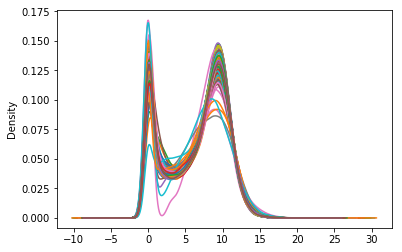

In [35]:
data.plot(kind='kde', legend=False) 

### Let's compare the above plot to the shape of the distribution after outlier filtering

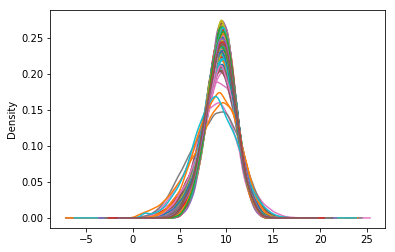

In [183]:
df_dropped.plot(kind='kde', legend=False)

* As shown, filtering outliers from our data appears to have normalized our distribution
* Please note, the original dataset downloaded from TCGA was already normalized and log2 transformed
* If we're working with raw sequence data, we would need to normalize and transform the data
* Since the dataset has been normalized, the only additional preprocessing required is to split our data by sample type

### Split data into two dataframes:
* The first dataframe (df1) contains expression values for normal cells
* The second dataframe (df2) contains expression values for cancer cells

In [17]:
df1 = df_dropped.filter(regex = 'sample|11$', axis =1)
# Creating new dataframe with only columns containing expression values for normal cells

In [18]:
df1.shape

(11002, 72)

In [19]:
df2 = df_dropped.filter(regex = 'sample|01|05$', axis = 1)
# Creating new dataframe with only columns containing expression values for cancer cells

In [20]:
df2.shape

(11002, 535)

### Generate density plots to visualize the shape of the distribution after outlier removal

#### KDE plots of processed data separated by sample type (cancer/normal)

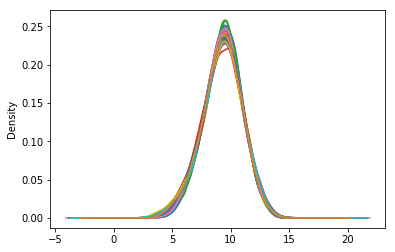

In [188]:
df1.plot(kind='kde', legend=False) # normal cells

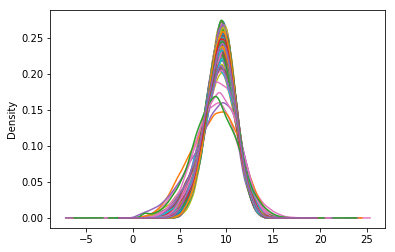

In [189]:
df2.plot(kind='kde', legend=False) # cancer cells

As expected, splitting our data by sample type did not affect the shape of the distribution

### Add columns with row-wise mean & variance to gene exp dataframes

In [21]:
import warnings
warnings.simplefilter("ignore")
from scipy.stats import ttest_ind, ttest_ind_from_stats


df1['mean1'] = df1[df1.columns].mean(axis=1)
df1['variance1'] = df1[df1.columns].var(axis=1)
df2['mean2'] = df2[df2.columns].mean(axis=1)
df2['variance2'] = df2[df2.columns].var(axis=1)



In [22]:
df1_stats = df1[['mean1', 'variance1']]
df1_stats.head()

,mean1,variance1
sample,,
ARHGEF10L,10.587401,0.124498
RNF10,12.214072,0.057677
RNF11,11.827933,0.047012
RNF13,10.933962,0.038483
GTF2IP1,12.697869,0.083764


In [23]:
df2_stats = df2[['mean2', 'variance2']]
df2_stats.head()

,mean2,variance2
sample,,
ARHGEF10L,10.132370,0.506471
RNF10,11.675401,0.102617
RNF11,11.322741,0.198024
RNF13,10.980765,0.231565
GTF2IP1,12.394156,0.192427


### Concatenate mean/variance columns of gene exp dataframes

In [24]:
df = pd.concat([df1_stats, df2_stats], axis=1)

In [25]:
df1.shape

(11002, 74)

In [26]:
df2.shape

(11002, 537)

### Visualize the new dataframe to confirm proper formatting

In [27]:
df.head(3)

,mean1,variance1,mean2,variance2
sample,,,,
ARHGEF10L,10.587401,0.124498,10.132370,0.506471
RNF10,12.214072,0.057677,11.675401,0.102617
RNF11,11.827933,0.047012,11.322741,0.198024


# T-statistic vs the negative binomial method of DE analysis:
* At one time the Poison distribution was used to test for differential expression
* However, the Poison distribution is too restrictive and does a poor job of controlling the false discovery rate
* To address this over-disperson problem, count data can be modeled with negative binomial distributions
* The negative binomial (NB) method works extremely well for small datasets
* NB assumes the mean and variance are related (using a single proportionality constant)
* However, the t-test method uses the actual mean and variance
* Thus, if the sample size is large (as is the case here), the t-test method is appropriate

# Differential expression analysis
* Run t-test and load results in new column
* Sort results 
* Print top 25 differentially expressed genes

In [28]:
df['ttest'] = abs((df['mean1'] - df['mean2'])/(np.sqrt(df['variance1']/74 + df['variance2']/537)))

In [29]:
diffexp_results = df['ttest']
diffexp = diffexp_results.sort_values(ascending=False)
diffexp.shape

(11002,)

## The top 25 differentially expressed genes:

In [30]:
results = diffexp.iloc[1:25]
results

sample
NOL3        41.102853
BRCC3       39.666073
C7orf68     39.328517
SLC15A4     38.738762
DDB2        37.573465
ZNF395      36.747181
SPAG4       36.731714
KRBA1       36.530676
MECOM       35.674698
PIP4K2C     35.659240
SLC2A12     34.815115
ANXA9       34.602081
TMEM91      34.378348
CLEC2D      34.314237
C9orf100    34.303152
MAN1C1      33.959008
KLHL13      33.840880
SAP30       33.778910
EPB41L5     33.239333
LRRC16A     32.981177
ATP6V1H     32.723150
NETO2       32.702144
SEMA5B      32.670660
SNX33       32.656142
Name: ttest, dtype: float64